# Get Data

In [1]:
import os
import numpy as np
import pandas as pd

# 用Quandl获取行情数据
# import quandl 
# API_KEY = "gG8vr-_3fVigtYzrQf5B" 
# quandl.ApiConfig.api_key = API_KEY

# 用yahoo-finance获取股市行情指数
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override() # <== that's all it takes :-)


In [2]:
def get_data(symbol=['AAPL'], startdate = "2015-01-01", enddate = "2019-02-19", download = True):
    # 股票名称 —— 用户输入
    _symbol = symbol #默认为AAPL
    # 数据开始日期
    _startdate = startdate
    # 数据结束日期
    _enddate = enddate
    # 是否需要下载
    _download = download
    
    # 用于存放数据列表
    data_dict = dict()
    # 市场数据标签
    market_dict={'sp500':'^GSPC','rus2000':'^RUT','vix': '^VIX','_10yr_bond':'^TNX','_13wk_bill':'^IRX', 'gold':'GLD','oil':'USO','WFC':'WFC'}
    # 股票数据标签
    for item in _symbol:
        market_dict[item] = item
        
    # 需要下载数据
    if _download == True:
        try:
            for key in market_dict.keys():
                value = market_dict[key]
                data = pdr.get_data_yahoo(value, start = _startdate, end = _enddate)
                data.reset_index(drop = True)
                data.to_csv("{}.csv".format(key))
                data_dict[key] = data
            return data_dict
        # 处理网络异常错误
        except IOError as e:
            print(e)
            
    # 从本地获取数据
    try:
        for key in market_dict.keys():
            # 读取本地数据
            data = pd.read_csv("{}.csv".format(key))
            data_dict[key] = data
        return data_dict
    except IOError as e:
        print(e)
        return None
        

In [3]:
data_dict = get_data(['AAPL'],download=False)

In [30]:
bank = pdr.get_data_yahoo('AAPL', start = "2015-01-01", end = "2019-02-20")
bank.to_csv("AAPL.csv")

[*********************100%***********************]  1 of 1 downloaded


In [5]:
data_dict = get_data(['GOOG','MSFT','AAPL'],download=False)

# Data Preprocess

In [20]:
import technical_indicators
import pandas as pd 
import numpy as np

def data_preprocess(data_dict, split_ratio = 0.8):
    # 获取数据字典
    _data_dict = data_dict
    # 获取数据字典的key，转化为列表存储
    _data_dict_keys = list(data_dict.keys())
    # 获取数据分割比例
    _split_ratio = split_ratio
    
    market_key_list = ['sp500','rus2000','vix','_10yr_bond','_13wk_bill', 'gold','oil','WFC']
    stock_key_list = list()
    for item in _data_dict_keys:
        if item not in market_key_list:
            stock_key_list.append(item)

    # 处理market_data
    sp500 = data_dict['sp500']
    sp500 = sp500.set_index(['Date'])
    sp500 = sp500[['Open','Adj Close','Volume']]
    sp500 = sp500.rename(columns={"Open": "sp500_open", "Adj Close": "sp500_adj_close", "Volume": "sp500_volume"})
    
    rus2000 = data_dict['rus2000']
    rus2000 = rus2000.set_index(['Date'])
    rus2000 = rus2000[['Open','Adj Close','Volume']]
    rus2000 = rus2000.rename(columns={"Open": "rus2000_open", "Adj Close": "rus2000_adj_close", "Volume": "rus2000_volume"})
    
    result = sp500.join(rus2000)
    
    vix = data_dict['vix']
    vix = vix.set_index(['Date'])
    vix = vix[['Open','Adj Close']]
    vix = vix.rename(columns={"Open": "vix_open", "Adj Close": "vix_adj_close"})

    result = result.join(vix)
    
    _10yr_bond = data_dict['_10yr_bond']
    _10yr_bond = _10yr_bond.set_index(['Date'])
    _10yr_bond = _10yr_bond[['Open','Adj Close']]
    _10yr_bond = _10yr_bond.rename(columns={"Open": "_10yr_bond_open", "Adj Close": "_10yr_bond_adj_close"})

    result = result.join(_10yr_bond)
    
    _13wk_bill = data_dict['_13wk_bill']
    _13wk_bill = _13wk_bill.set_index(['Date'])
    _13wk_bill = _13wk_bill[['Open','Adj Close']]
    _13wk_bill = _13wk_bill.rename(columns={"Open": "_13wk_bill_open", "Adj Close": "_13wk_bill_adj_close"})
   
    result = result.join(_13wk_bill)

    gold = data_dict['gold']
    gold = gold.set_index(['Date'])
    gold = gold[['Open','Adj Close','Volume']]
    gold = gold.rename(columns={"Open": "gold_open", "Adj Close": "gold_adj_close", "Volume": "gold_volume"})
   
    result = result.join(gold)

    oil = data_dict['oil']
    oil = oil.set_index(['Date'])
    oil = oil[['Open','Adj Close','Volume']]
    oil = oil.rename(columns={"Open": "oil_open", "Adj Close": "oil_adj_close", "Volume": "oil_volume"})
   
    result = result.join(oil)

    wfc = data_dict['WFC']
    wfc = wfc.set_index(['Date'])
    wfc = wfc[['Open','Adj Close','Volume']]
    wfc = wfc.rename(columns={"Open": "wfc_open", "Adj Close": "wfc_adj_close", "Volume": "wfc_volume"})
    # 合并market dataframe
    result = result.join(wfc)
    result = result.dropna()
    
    # market数据行数
    market_rows = result.shape[0]
    # market数据列数
    market_cols = result.shape[1]
    
    # 处理stock_data
#     i = 0
    for item in stock_key_list:
        symbol = item
#         print(item)
        data = data_dict[symbol]
#         print(data)
        # 初始化交易价格
        data["trade_price"] = (data['High'] + data['Low'])/2
        data = technical_indicators.accumulation_distribution(data, 20)
        data = technical_indicators.bollinger_bands(data, 20)
        data = technical_indicators.macd(data, 12, 26)
        data = technical_indicators.money_flow_index(data, 20)
        data = data.set_index(['Date'])
        # 初始化股票价值为0（默认当前未持股）
#         data["stock_value"] = 0.          
        data = data[['Open', 'trade_price', 'Close', 'Adj Close', 'Volume', 'Acc/Dist_ROC_20', 'BollingerB_20', 'Bollinger%b_20', 'MACD_12_26', 'MACDsign_12_26', 'MACDdiff_12_26', 'MFI_20']] 
        data = data.rename(columns={"Open": "{}_open".format(symbol), "trade_price":"{}_trade_price".format(symbol),"Close": "{}_close".format(symbol), "Adj Close": "{}_adj_close".format(symbol), "Volume": "{}_volume".format(symbol),
                                   "Acc/Dist_ROC_20":"{}_ad".format(symbol), "BollingerB_20":"{}_BB".format(symbol), "Bollinger%b_20":"{}_Bb".format(symbol), "MACD_12_26":"{}_macd".format(symbol),
                                   "MACDsign_12_26":"{}_macd_s".format(symbol),"MACDdiff_12_26":"{}_macd_d".format(symbol), "MFI_20":"{}_mfi".format(symbol)}) 
    
        result = result.join(data)
#         i = i + 1
    # 初始化现金为100000. (默认初始资本为10w)
#     result['cash'] = 100000.
    result = result.dropna()
    # stock数据行数
    stock_rows = result.shape[0]
    # stock数据列数
    stock_cols = result.shape[1] - market_cols
    
    date = list(result.index)
    column_name = result.columns.values
#     print(column_name)
                                           
    process_column = ['sp500_open', 'rus2000_open', 'vix_open', '_10yr_bond_open', '_13wk_bill_open', 'gold_open',
                       'oil_open', 'wfc_open']
    # 加入待处理的股票开盘价列表
    for s in stock_key_list:
        process_column.append("{}_open".format(s))
        process_column.append("{}_close".format(s))

    for c in process_column:
        # 获取open
        _open = result[c]
        # open后移一位,转为list
        _open = list(_open[1:])
        # 最后加入nan，以匹配其余数据长度
        _open.append(np.nan)
        # 替换原数据
        result[c] = _open
    # 删除nan值
    result = result.dropna()
    # 调整索引日期
    date.remove(date[0])
    # 重新设置索引
    result.reindex(date)
    
    c_close_list = list()
    for s in stock_key_list:
        c_close_list.append(result["{}_close".format(s)])
        result.drop(["{}_close".format(s)],axis=1,inplace=True)
#     print(c_close_list)
#     print(result)
    print(result.columns.values)
    
    # 数据总行数
#     rows = result.shape[0]
    rows = 200
    # 训练数据条数
    n_train = int(np.round(_split_ratio * rows))
    # 测试数据条数
    n_test = rows - n_train
    
    # 训练数据集
    train = result.iloc[:n_train]
    train_close = list()
    for close_list in c_close_list:
        train_close.append(close_list.iloc[:n_train])
    # 测试数据集
    test = result.iloc[-n_test:]
    test_close = list()
    for close_list in c_close_list:
        test_close.append(close_list.iloc[-n_test:])
    
    return train, test, train_close, test_close
    

In [21]:
train, test, train_close, test_close = data_preprocess(data_dict)

['sp500_open' 'sp500_adj_close' 'sp500_volume' 'rus2000_open'
 'rus2000_adj_close' 'rus2000_volume' 'vix_open' 'vix_adj_close'
 '_10yr_bond_open' '_10yr_bond_adj_close' '_13wk_bill_open'
 '_13wk_bill_adj_close' 'gold_open' 'gold_adj_close' 'gold_volume'
 'oil_open' 'oil_adj_close' 'oil_volume' 'wfc_open' 'wfc_adj_close'
 'wfc_volume' 'AAPL_open' 'AAPL_trade_price' 'AAPL_adj_close'
 'AAPL_volume' 'AAPL_ad' 'AAPL_BB' 'AAPL_Bb' 'AAPL_macd' 'AAPL_macd_s'
 'AAPL_macd_d' 'AAPL_mfi']


In [ ]:
columns = ['sp500_open' 'sp500_adj_close' 'sp500_volume' 'rus2000_open'
 'rus2000_adj_close' 'rus2000_volume' 'vix_open' 'vix_adj_close'
 '_10yr_bond_open' '_10yr_bond_adj_close' '_13wk_bill_open'
 '_13wk_bill_adj_close' 'gold_open' 'gold_adj_close' 'gold_volume'
 'oil_open' 'oil_adj_close' 'oil_volume' 'wfc_open' 'wfc_adj_close'
 'wfc_volume' 'AAPL_open' 'AAPL_trade_price' 'AAPL_adj_close'
 'AAPL_volume' 'AAPL_ad' 'AAPL_BB' 'AAPL_Bb' 'AAPL_macd' 'AAPL_macd_s'
 'AAPL_macd_d' 'AAPL_mfi']

# Environment Prepare

In [32]:
from tensorforce.environments import Environment
import pandas as pd 
import numpy as np 


class StockEnv(Environment):
    
    def __init__(self, data, close, order_size = 100):
        
        # 获取股价数据
        self.origin_data = data
        # 单次交易的股数
        self.order_size = order_size
        # 根据当日收盘价列表个数，可以知道股票个数为n，第n个是要操作的股票，前面n-1个是新增的feature（除market之外新增的）
        if len(close) == 1:
            self.num_stock = 0
            self.close_data = close[0]
        else:
            self.num_stock = len(close) - 1
            # 获取待预测股票的当日收盘价
            self.close_data = close[-1]  # 取最后一个列表的close

        # 全部feature列表
        self.features = self.origin_data.columns.values
        # 全部index列表
        self.date = list(self.origin_data.index)

        # 根据data preprocess得到的column，market共有21个feature, 单只stock共有11个feature
        self.market_feature_len = 21
        self.stock_feature_len = 11

        # 初始化环境
        self.reset() 
        
    def __str__(self):
        return 'StockEnvironment'

    def close(self):
        """
        Close environment. No other method calls possible afterwards.
        """
        print('Over!')

    def seed(self, seed):
        """
        Sets the random seed of the environment to the given value (current time, if seed=None).
        Naturally deterministic Environments (e.g. ALE or some gym Envs) don't have to implement this method.
        Args:
            seed (int): The seed to use for initializing the pseudo-random number generator (default=epoch time in sec).
        Returns: The actual seed (int) used OR None if Environment did not override this method (no seeding supported).
        """
        return None

    def reset(self):
        """
        Reset environment and setup for new episode.
        Returns:
            initial state of reset environment.
        """
        # 获取样本个数
        self.sample_size = len(self.origin_data)
        # 训练次数初始化
        self.step_counter = 0  
        # 动作个数初始化
        self.n_actions = len(self.actions)
        # 奖励初始化
        self.reward = 0.
        # 持有现金初始化
        self.cash_hold = 100000.
        # 持有股票数量初始化
        self.stock_amount = 0 
        # 股票价值初始化
        self.past_stock_value = 0.
        self.stock_value = 0. 
        # next state 初始化
        self.next_states = self.states
        # 交易价格初始化
        self.trade_price = self.states[-13]
        # 估值价格初始化
        self.cal_value_price = self.close_data[self.step_counter]
        
        # 当前资本总值初始化，一开始为10万
        self.current_value = 100000.
        # 过去资本总值初始化，一开始与当前资本总值相同
        self.past_value = self.current_value 
        
        # 当前是否为结束状态
        self.done = False 
        

    def execute(self, action):
        """
        Executes action, observes next state(s) and reward.
        Args:
            actions: Actions to execute.
        Returns:
            Tuple of (next state, bool indicating terminal, reward)
        """
        # 更新past_value为当前资本总值
        self.past_value = self.current_value
        # 更新past_stock_value为当前股票总值
        self.past_stock_value = self.stock_value
        
        # 更新cash、stock_value等信息
        if action == 1: #'buy'
            # 更新cash总值
            self.cash_hold = self.cash_hold - self.trade_price * self.order_size
            # 更新stock数量
            self.stock_amount = self.stock_amount + self.order_size
            # 更新stock value
            self.stock_value = self.cal_value_price * self.stock_amount  
        if action == 2: #'sell'
            # 更新cash总值
            self.cash_hold = self.cash_hold + self.trade_price * self.order_size
            # 更新stock数量
            self.stock_amount = self.stock_amount - self.order_size
            # 更新stock value
            self.stock_value = self.cal_value_price * self.stock_amount
        if action == 0: #'hold'
            # 更新stock value
            self.stock_value = self.cal_value_price * self.stock_amount
            
        # 更新当前资本总值 （当前现金+股票价值）    
        self.current_value = self.cash_hold + self.stock_value
        
        # 更新states状态
        # 如果还有下一状态，执行以下操作
        if self.step_counter + 1 < self.sample_size:
            self.done = False
            self.step_counter = self.step_counter + 1
            # 更新stock的price、volume、indicator等状态
            self.next_states = self.states
            # 更新trade price
            self.trade_price = self.next_states[-13]
            # 更新 cal value price
            self.cal_value_price = self.close_data[self.step_counter]
        # 如果没有下一状态，执行以下操作
        else:
            self.done = True

#          # 多方： 持有股数大于0，若股票升值给与奖励，若股票贬值给予惩罚
#         if self.stock_amount > 0 and self.stock_value > self.past_stock_value:
#             self.reward = self.reward + 0.1
#         if self.stock_amount > 0 and self.stock_value < self.past_stock_value:                
#             self.reward = self.reward - 0.1
#         # 空方： 持有股数小于0，若股票贬值给与奖励，若股票升值给予惩罚
#         if self.stock_amount < 0 and self.stock_value < self.past_stock_value:
#             self.reward = self.reward + 0.1
#         if self.stock_amount < 0 and self.stock_value > self.past_stock_value:
#             self.reward = self.reward - 0.1
    
    
        # 以下情形给予特别惩罚：
        
        # 1. 资本总值亏损70%离场;   
        if self.current_value <= 30000.:
            self.reward = self.reward - 1000.
        # 2. 现金数量 < 0 且没有足够股票卖出抵债; 
        if self.cash_hold <= 0. and (np.abs(self.cash_hold) >= self.stock_value): 
            print(self.cash_hold)
            print(self.stock_value)
            self.reward = self.reward - 1000.
        # 3. 卖空操作时，没有足够的现金买回股票; 
        if self.stock_amount <= 0 and (np.abs(self.stock_value) >= self.cash_hold):
            print(self.cash_hold)
            print(self.stock_value)
            self.reward = self.reward - 1000.
        # 4. 今天比昨天的财富总值更少
#         if self.current_value < self.past_value:
#             self.reward = self.reward - 0.2
        
        # 以下情形给予特别奖励：
        # 1. 总资本大于13万给予大奖励，即收益率超过50%;
        if self.current_value >= 150000.:
            self.reward = self.reward + 1.
        # 2. 今天比昨天的财富总值更多;
#         if self.current_value > self.past_value:
#             self.reward = self.reward + 0.2   

        # 常规的奖励与惩罚
        self.reward = self.reward + (self.current_value - 100000.) / 100000. + (self.current_value - self.past_value) / self.past_value
            

        return self.next_states, self.done, self.reward 
    
    
    @property
    def states(self):
        """
        Return the state space. Might include subdicts if multiple states are 
        available simultaneously.
        Returns:
            States specification, with the following attributes
                (required):
                - type: one of 'bool', 'int', 'float' (default: 'float').
                - shape: integer, or list/tuple of integers (required).
        """
        # 从传入的数据获取市场、股价等信息
        states = self.origin_data.iloc[self.step_counter]
        # 增加当前stock value、cash、total fortune为状态信息
        states['stock_value'] = self.stock_value
        states['cash'] = self.cash_hold
        states['fortune'] = self.stock_value + self.cash_hold
        # 将dataframe转为ndarray，以提高运算速度
        states_np = np.array(states)
        
        return states_np



    @property
    def actions(self):
        """
        Return the action space. Might include subdicts if multiple actions are 
        available simultaneously.
        Returns:
            actions (spec, or dict of specs): Actions specification, with the following attributes
                (required):
                - type: one of 'bool', 'int', 'float' (required).
                - shape: integer, or list/tuple of integers (default: []).
                - num_actions: integer (required if type == 'int').
                - min_value and max_value: float (optional if type == 'float', default: none).
        """
        # 每只股票都三种情况: 0 - hold; 1 - buy; 2 - sell
        actions = [0, 1, 2]
        
        return actions


    @staticmethod
    def from_spec(spec, kwargs):
        """
        Creates an environment from a specification dict.
        """
        env = tensorforce.util.get_object(
            obj=spec,
            predefined_objects=tensorforce.environments.environments,
            kwargs=kwargs
        )
        assert isinstance(env, Environment)
        return env

# DQN Model

In [33]:
import numpy as np
import random
from collections import deque
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam, SGD


class DQN:
    def __init__(self, env):
        # 传入训练环境env
        self.env = env
        # 初始化参数
        self.memory  = deque(maxlen=500)  # 记忆队列，最大记忆量为2000
        # 奖励折扣率
        self.gamma = 0.9  
        # 贪心度 
        self.epsilon = 1.0
        # 贪心度最小值
        self.epsilon_min = 0.01 
        # 贪心度折扣率
        self.epsilon_decay = 0.995
        # 学习率
        self.learning_rate = 0.001
        # 权重更新比重
        self.tau = 0.05
        #批处理个数
        self.batch_size = 32

        # 创建评估网络 eval_model
        self.eval_model = self.create_model()
        # 创建目标网络 target_model
        self.target_model = self.create_model()

    def create_model(self):

#         # 创建深度学习网络模型
#         model = Sequential()

#         # 传入数据，第一层为全连接层，输出节点个数为32
#         model.add(Dense(32, input_dim=1, activation="relu"))
#         model.add(Dropout(0.5))

#         # 第二层为全连接层，输出节点个数为64
#         model.add(Dense(64, activation="relu"))
#         model.add(Dropout(0.5))

#         # 第三层为全连接层，输出个数为32
#         model.add(Dense(32, activation="relu"))
#         model.add(Dropout(0.5))

#         # 第四层为全连接层，输出一个结果，有三种可能值
#         model.add(Dense(self.env.n_actions, activation="softmax")) # linear

#         # 依据上述设置，创建网络模型
#         model.compile(loss="mean_squared_error", optimizer=Adam(lr=self.learning_rate))

       
        model = Sequential()
         # 32 features 
        model.add(Dense(32, input_dim=1,activation='relu'))
        model.add(Dropout(0.5))
        # 张清明 得到经验公式 隐层单元数 = (输入矢量维数+ max(输入节点数,目标分类数))/2
        model.add(Dense(16, activation='relu'))
        model.add(Dropout(0.5))
        # 3 outputs
        model.add(Dense(self.env.n_actions, activation='softmax'))
        # 系数据正的loss用sparse_categorical_crossentrop，非稀疏矩阵用categorical_crossentropy，optimizer=Adam(lr=self.learning_rate)
        model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=self.learning_rate),metrics=['accuracy'])
    
        return model

    def act(self, state):
        # 更新贪心度值
        self.epsilon *= self.epsilon_decay
        # 在 epsilon 和 epsilon_min 之间，取两者中的较大者为最新的贪心度值
        self.epsilon = max(self.epsilon_min, self.epsilon)
        # 若随机数小于贪心度，进入探索模式，随机选取动作
        if np.random.random() < self.epsilon:
            return np.random.randint(0, self.env.n_actions)
        # 否则按照评估网络 eval_model 预测动作
        return np.argmax(self.eval_model.predict(state)[0])

    def remember(self, state, action, reward, new_state, done):
        # 记忆已训练过的状态数据
        self.memory.append([state, action, reward, new_state, done])

    def replay(self):
        # 设置批处理数量
        batch_size = self.batch_size
        # 若记忆数据量小于批处理个数
        if len(self.memory) < batch_size: 
            # 直接返回，不进行回放学习
            return
        # 若记忆数据量大于批处理个数，则继续如下回放学习步骤
        # 从记忆序列memory中选择batch_size个随机且独立的元素，用作回放样本
        samples = random.sample(self.memory, batch_size)
        # 遍历随机选出的样本
        for sample in samples:
            # 取出状态数据
            state, action, reward, new_state, done = sample
            # 使用target_model再次预测，预测结果存入target
            target = self.target_model.predict(state)
            # 若取出的是终结状态时的数据
            if done:
                # 直接使用原来的reward 
                target[0][action] = reward
            else:
                # 选取下一个状态中最大的reward，记为Q_future
                Q_future = max(self.target_model.predict(new_state)[0])
                # 使用打折后的Q_future，更新reward
                target[0][action] = reward + Q_future * self.gamma
            # 使用取出的state和更新后的target再次训练评估网络eval_model
            self.eval_model.fit(state, target, epochs=1, verbose=0)

    def target_train(self):
        # 获取评估网络eval_model的权重参数
        eval_weights = self.eval_model.get_weights()
        # 获取目标网络target_model的权重参数
        target_weights = self.target_model.get_weights()
        # 逐个更新target_model的权重参数
        for i in range(len(target_weights)):
            # 通过tau调节评估网络eval_model和目标网络target_model权重参数的比重，组合起来更新target_model的权重参数
            target_weights[i] = eval_weights[i] * self.tau + target_weights[i] * (1 - self.tau)
        # 设置更新后的权重参数到目标网络target_model
        self.target_model.set_weights(target_weights)
        
    def save_model(self, fn):
        # 保存评估网络eval_model的模型
        self.eval_model.save(fn)



# Runner

In [34]:
# import StockEnvironment
# import DQN

import numpy as np
import tensorflow as tf
from keras import backend as K
from keras.models import load_model

# 全局变量

class Runner:
    def __init__(self):
        # 使用模型之前，添加这两行代码清空之前model占用的内存
        K.clear_session()
        tf.reset_default_graph()
        
        # 初始化奖励折扣率
        self.gamma = 0.9
        # 初始化贪心度
        self.epsilon = 1.0
        # 初始化贪心度最小值
        self.epsilon_min = 0.01 
        # 初始化贪心度折扣率
        self.epsilon_decay = 0.995  
        # 标志位，用来表示是否训练出收益率较高的成功模型
        self.train_success = False
        # runner运行结束后，需要返回最终训练出的模型的名字，以便测试
        self.model_name = ''
        
    def trainer(self, symbol, env, epochs):
        # 获取环境
        self.env = env
        # 初始化dqn_agent
        self.dqn_agent = DQN(env=self.env)
        # 初始化执行轮次
        self.epochs = epochs
        # 初始化每轮次的训练步数
        self.epoch_len = self.env.sample_size

        # 开始执行epochs轮次的训练
        for epoch in range(self.epochs):
            # 初始化训练环境
            self.env.reset()
            # 获取当前状态
            cur_state = self.env.states
            # 初始化资本总值记录
            fortune = list()
            # 初始化股票价值
            stock = list()
            # 初始化持有现金
            cash = list()
            # 初始化动作记录
            act = list()
            # 初始化奖励记录
            re = list()
            # 开始本轮的训练
            for step in range(self.epoch_len):
                # 根据当前状态选择action
                action = self.dqn_agent.act(cur_state)
                # 执行action，返回环境中的下一个状态
                new_state, done, reward = self.env.execute(action)

                # 记录当前采取的行动，添加到action记录表
                act.append(action)
                # 记录当前返回的奖励，添加到reward记录表
                re.append(reward)
                # 记录当前持有的股票价值，添加到stock记录表
                stock.append(new_state[-3])
                # 记录当前持有的现金，添加到cash记录表
                cash.append(new_state[-2])
                # 记录当前状态的资本总值，添加到fortune记录表
                fortune.append(new_state[-1])

                # 存入回放记忆
                self.dqn_agent.remember(cur_state, action, reward, new_state, done)
                # 经验回放
                self.dqn_agent.replay() 
                if step > 20:
                    # 更新模型参数
                    self.dqn_agent.target_train() 
                # 获取下一个状态
                cur_state = new_state

                # 若为结束状态，跳出循环；否则继续训练
                if done:
                    # 训练出成功模型，保存前缀名为success的模型
                    if fortune[-1] >= 150000.:
                        self.train_success = True
                        self.model_name = "success-model-{}-{}.h5".format(symbol, epoch)
                        self.dqn_agent.save_model(self.model_name)
                    # 训练未成功，保存前缀名为train的模型
                    else:
                        self.train_success = False
                        self.model_name = "train-model-{}-{}.h5".format(symbol, epoch)
                        self.dqn_agent.save_model(self.model_name)
                    break
            
            print("Epoch {}: Fortune-{}, Cash-{}, Reward-{}".format(str(epoch), fortune[-1], cash[-1], re[-1]))    
#             # 输出训练的最终资本总值
#             print("Fortune for epoch " + str(epoch) + " : ")
#             print(fortune[-1])
#             # 输出本轮次所有行为
#             print("Actions for epoch " + str(epoch) + ":")
#             print(act)
#             # 输出本轮次所有奖励
#             print("Rewards for epoch "+ str(epoch) + ":")
#             print(re)
#             # 输出本轮次所有现金
#             print("Cash for epoch " + str(epoch) + ":")
#             print(cash)
            
        # 完成所有轮次训练后，返回训练后的模型名称       
        return self.model_name
                       

    def tester(self, env, model_name):
        # 根据测试数据，初始化环境
        self.env = env
        # 初始化每轮次的训练步数
        self.epoch_len = self.env.sample_size
        # # 初始化model_name
        self.model_name = model_name
        # 根据模型名称，载入模型
        self.test_model = load_model(self.model_name)


        # 初始化测试环境
        self.env.reset()
        # 获取当前状态
        cur_state = self.env.states
        # 初始化资本总值记录
        fortune = list()
        # 初始化持有现金
        cash = list()
        # 初始化动作记录
        act = list()
        # 初始化奖励记录
        re = list()
        # 开始测试
        for step in range(self.epoch_len):
            # # 使用现有模型，根据当前状态选择action
#             action = np.argmax(self.test_model.predict(cur_state)[0])
            
            # 更新贪心度值
            self.epsilon *= self.epsilon_decay
            # 在 epsilon 和 epsilon_min 之间，取两者中的较大者为最新的贪心度值
            self.epsilon = max(self.epsilon_min, self.epsilon)
            # 若随机数小于贪心度，进入探索模式，随机选取动作
            if np.random.random() < self.epsilon:
                action = np.random.randint(0, self.env.n_actions)
            # 否则按照评估网络 test_model 预测动作
            else:
                action = np.argmax(self.test_model.predict(cur_state)[0])

            # 执行action，返回环境中的下一个状态
            new_state, done, reward = self.env.execute(action)
            
            # 记录当前采取的行动，添加到action记录表
            act.append(action)
            # 记录当前返回的奖励，添加到reward记录表
            re.append(reward)
            # 记录当前持有的现金，添加到cash记录表
            cash.append(new_state[-2])                
            # 记录当前状态的资本总值，添加到fortune记录表
            fortune.append(new_state[-1])

            # 获取下一个状态
            cur_state = new_state

            # 若为结束状态，跳出循环；否则继续训练            
            if done:
                break
        
        print("Test Result: Fortune-{}, Cash-{}, Reward-{}".format(fortune[-1], cash[-1], re[-1]))          
        # 输出测试的最终资本总值
#         print("Test Fortune :")
#         print(fortune[-1])
#         # 输出测试的所有行为
#         print("Test Actions :")
#         print(act)
#         # 输出测试的所有奖励
#         print("Test Rewards :")
#         print(re)
#         # 输出测试的所有现金
#         print("Test Cash :")
#         print(cash)

        # 返回结果，用于画图
        return fortune, act, re, cash

                

In [35]:
env = StockEnv(train, train_close)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:914: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc[key] = value
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [36]:
# 初始化runner
runner = Runner()
# 训练dqn网络，返回训练完毕的模型，以及训练最终结果; 显示训练情况图
trained_model = runner.trainer('AAPL', env, 5)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:914: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc[key] = value
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Epoch 0: Fortune-64770.99245000002, Cash--469516.99795, Reward--14.614518803749503
-967455.50165
962975.9916000001
-978932.50165
978604.9745
-1013827.00165
998711.9824
-1036655.0014999999
1036350.018
-1059703.0015500002
1058092.0184
-1071263.0014000002
1047645.0186
-1082562.0011500001
994144.0188
-1093439.50135
979640.0285
-1103479.5015
995903.9808
-1114210.00155
1063993.0194
-1103463.0014499999
1084031.9808
-1114626.0011999998
1098913.0097
-1125868.50115
1105048.0196
-1137195.0011
1066428.0099
-1148157.001
1123399.96
-1159230.5006499998
1114737.0303
-1170371.5006499998
1114553.9694
-1181319.5006
1156792.9793999998
-1192463.5004999998
1145560.0208
-1203653.0002
1181985.0
-1214812.0002499998
1210625.9893999998
-1249257.0002999997
1241727.9782
-1260767.5002499998
1247949.967
-1260624.5001999997
1247400.022
-1271959.5000499997
1268952.0
-1306289.5003499996
1281816.0228000002
-1317640.0004499997
1254189.977
-1306571.5002999997
1257420.0342
-1317585.0004999996
1260170.0229999998
-1328431.50

In [37]:
env_test = StockEnv(test, test_close)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:914: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc[key] = value
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [38]:

model_name = 'train-model-AAPL-4.h5'

fortune, act, reward, cash = runner.tester(env_test, model_name)
d = test
a = act
f = fortune
c = cash

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:914: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc[key] = value
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Test Result: Fortune-113724.0006, Cash--57076.00239999999, Reward-2.6534992539155104


In [42]:
import matplotlib.pyplot as plt
# %matplotlib inline


def plot_trade_point(data, act_list):
    # 载入数据 data，从中获取 Close Price
    open_price = data['AAPL_open']
    # 载入数据 act_list，从中获取 Act
    act = act_list
    # 新增画布
#     ax = figure.add_subplot(111)
    # 画布上添加 Close Price
    plt.plot(np.arange(len(open_price)), open_price)
    # 调整 X 轴坐标
    plt.xlim((0, len(open_price)))
    # 调整 Y 轴坐标
    plt.ylim((np.min(open_price), np.max(open_price)))
    # 设置 X 轴名称
    plt.xlabel('Steps')
    # 设置 Y 轴名称
    plt.ylabel('Price')
    # 设置图标名称
    plt.title('Trade Point predicted by DQN Trader')
        
    for i in range(len(act)):
        if act[i] == 1:
            plt.scatter(x = i, y = open_price[i], c = 'r', marker = 'o', linewidths = 0, label = 'Buy')
        if act[i] == 2:
            plt.scatter(x = i, y = open_price[i], c = 'g', marker = 'o', linewidths = 0, label = 'Sell')

    # 显示图标
    plt.show()

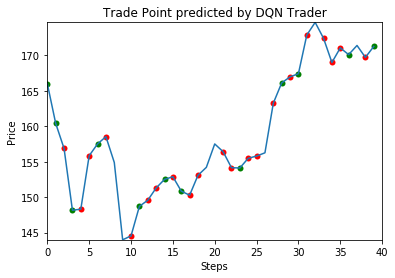

In [43]:
plot_trade_point(d,a)

In [34]:
(106466.00394999997-100000.)/100000.

0.0646600394999997

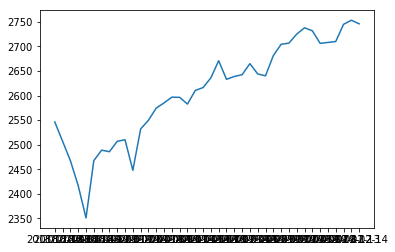

In [41]:
plt.plot(d['sp500_adj_close'])

In [35]:
(d['sp500_adj_close'].values[-1]-d['sp500_adj_close'].values[-0])/d['sp500_adj_close'].values[-0]

0.05178713694112936

In [43]:
def normalize_data(data):
#     print(data)
    normalized_data = (data - np.min(data)) / (np.max(data) - np.min(data))
#     print(normalized_data)
    return normalized_data

def cal_sharp_ratio(n_data):
#     n_min = np.min(n_data)
#     n_max = np.max(n_data)
    n_std = np.std(n_data)
    sharp_ratio = (n_data[-1]-n_data[0]) / n_std
    return sharp_ratio

# sp500
n_sp500 = normalize_data(d['sp500_adj_close'].values)
sp500_sharp_ratio = cal_sharp_ratio(n_sp500)
# AAPL
n_aapl = normalize_data(d['AAPL_adj_close'].values)
n_appl_std = np.std(n_aapl)
# aapl_sharp_ratio = cal_sharp_ratio(n_aapl)
# sp_data = np.array(d['sp500_adj_close'].values)
# n_sp_data = normalize_data(sp_data)
# sp_std = np.std(sp_data)

# sharp_ratio = (n_sp_data[-1]-n_sp_data[0])/sp_std
print(sp500_sharp_ratio)
# print(aapl_sharp_ratio)

1.8041200076753123
